# Application of ConvNet for Flowers Image Classification With Image Augmentation

In [1]:
# Import required packages
import os
import numpy as np
import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load flower dataset from Tensorflow example datasets on googleapis
URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

file_dir = tf.keras.utils.get_file("flower_photos.tgz", origin=URL, extract=True)

228813984/228813984 [==============================] - 3s 0us/step


In [3]:
# Check file directory of downloaded dataset
file_dir

'/root/.keras/datasets/flower_photos.tgz'

In [4]:
os.path.dirname(file_dir)

'/root/.keras/datasets'

In [5]:
# Return items list in the file directory
os.listdir(os.path.dirname(file_dir))

['flower_photos', 'flower_photos.tgz']

In [6]:
os.path.dirname(file_dir)

'/root/.keras/datasets'

In [7]:
# Create directory path for flower photos folder
base_dir = os.path.join(os.path.dirname(file_dir), "flower_photos")
base_dir

'/root/.keras/datasets/flower_photos'

In [8]:
# Return items/folders in flower photos directory folder
os.listdir(base_dir)

['tulips', 'dandelion', 'LICENSE.txt', 'daisy', 'sunflowers', 'roses']

In [9]:
# Create an array for all flower classes
flower_classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [10]:
# Create Train and Vlidation folders and split the flower images into them 80:20
for flower_class in flower_classes:
  image_path = os.path.join(base_dir, flower_class) # Return paths for all flower classes in the base dir
  flower_images = glob.glob(image_path + '/*.jpg') # Return all images from each flower class in array
  train_dataset, validation_dataset = flower_images[:round(len(flower_images)*0.8)], flower_images[round(len(flower_images)*0.8):] # Split images in train and validation 80% and 20% respectively

  # create flower class folders in the train folder and attach required images
  for train_image in train_dataset:
    if not os.path.exists(os.path.join(base_dir, 'train', flower_class)): # Check if train flower class path exists
      os.makedirs(os.path.join(base_dir, 'train', flower_class)) # if not, create one
    shutil.move(train_image, os.path.join(base_dir, 'train', flower_class)) # Move image to the flower class folder

  # create flower class folders in the validation folder and attach required images  
  for validation_image in validation_dataset:
    if not os.path.exists(os.path.join(base_dir, 'validation', flower_class)):  # Check if validation flower class path exists
      os.makedirs(os.path.join(base_dir, 'validation', flower_class)) # if not, create one
    shutil.move(validation_image, os.path.join(base_dir, 'validation', flower_class)) # Move image to the flower class folder


In [11]:
# Create file directory for train and validation folders
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
print('Train path: ', train_dir)
print('Validation path: ', validation_dir)

Train path:  /root/.keras/datasets/flower_photos/train
Validation path:  /root/.keras/datasets/flower_photos/validation


In [12]:
groups = ['train', 'validation']
for flower_class in flower_classes:
  for group in groups:
    print('Total {} {} images: {}'.format(group, flower_class, len(os.listdir(os.path.join(base_dir, group, flower_class)))))


Total train daisy images: 506
Total validation daisy images: 127
Total train dandelion images: 718
Total validation dandelion images: 180
Total train roses images: 513
Total validation roses images: 128
Total train sunflowers images: 559
Total validation sunflowers images: 140
Total train tulips images: 639
Total validation tulips images: 160


In [13]:
# Data augmentation generates more training data from training samples, by augmenting the samples through random transformations.
# ImageDataGenerator from Keras can be used to achieve this


# Set augmentation transformations for Train data
train_images_augmentation = ImageDataGenerator(
    rescale = 1/255, #Normalize all pixel values between 0 to 1
    horizontal_flip= True, #Flipping images horizontally
    rotation_range= 45, #Degree range for random rotations
    zoom_range=0.5,  # To Zoom into the images, set zoom_range < 1
    width_shift_range= 0.15,  # Shift horizontally by 15%
    height_shift_range= 0.15 # Shift vertically by 15%
)

# Set Rescale property only on validation data. This data will be used to test the model, Hence should contain exact properties
validation_images_augmentation = ImageDataGenerator(
  rescale=1./255
)

# Read the images directly from the directory with flow_from_directory() and augment them while the neural network model is learning on the training data.
# The method requires images belonging to different classes are present in different folders but are inside the same parent folder i.e train_dir. 

train_data_generated = train_images_augmentation.flow_from_directory(
    batch_size= 100, # Number of images to extract from the directory for every batch
    directory= train_dir, # Parent directory
    target_size=(150,150),  # resize images to this size
    shuffle=True, # Allow shuffling
    class_mode='sparse' #Number of classes to predict
)

validation_data_generated = validation_images_augmentation.flow_from_directory(
    batch_size= 100, # Number of images to extract from the directory for every batch
    directory= validation_dir, # Parent directory
    target_size=(150,150),  # resize images to this size
    shuffle=True, # Allow shuffling
    class_mode='sparse' #Number of classes to predict
)

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [14]:
# Plot images in the form of a grid with 2 rows and 5 columns where images are placed in each column and rows.
def plotImages(images):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

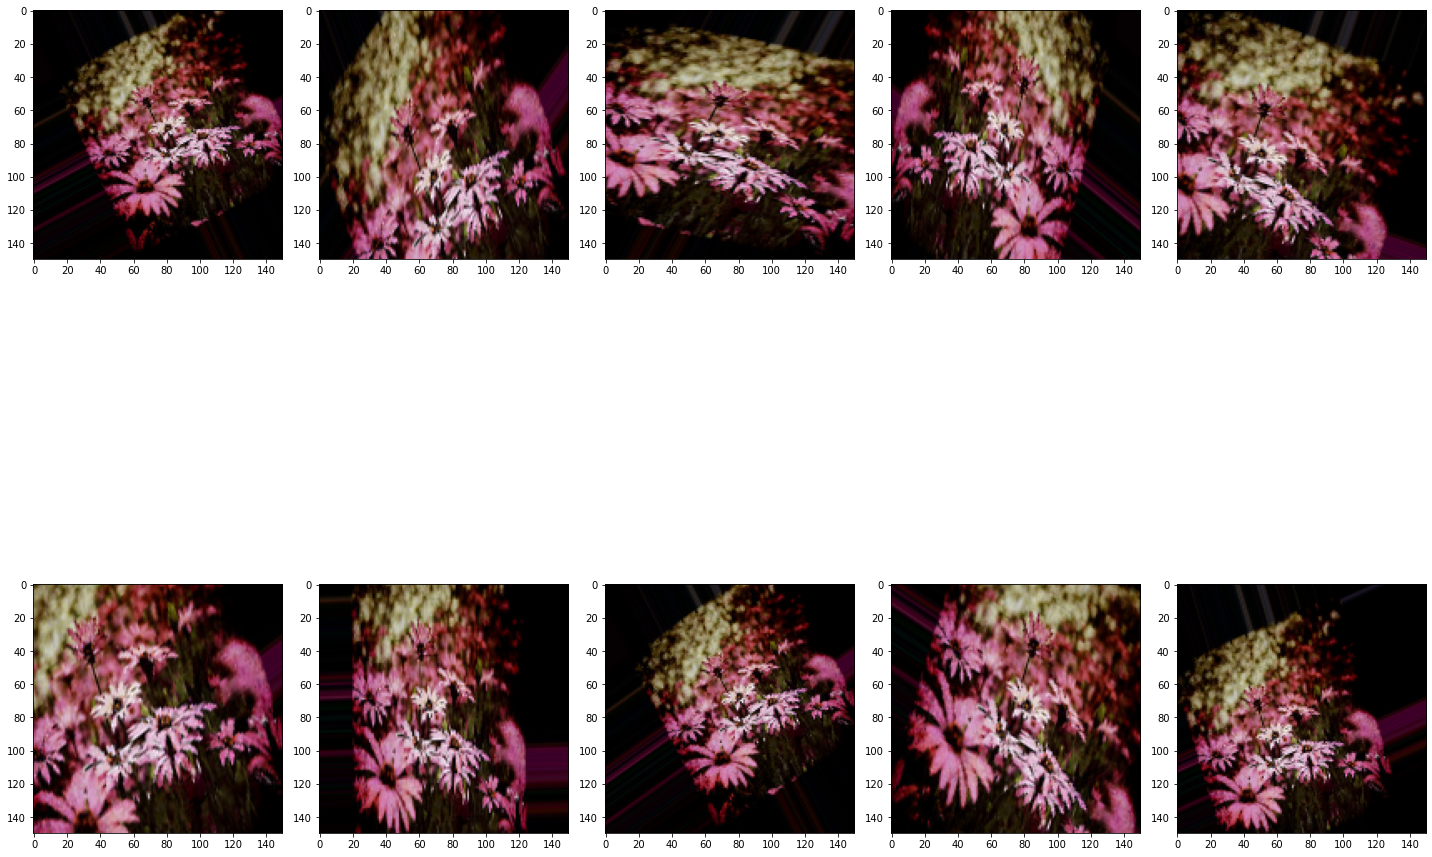

In [15]:
plotImages([train_data_generated[0][0][0] for i in range(10)])

In [16]:
# Designing the layers of the convolutional neural network.

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu"), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation="softmax")
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [18]:
# Compiling the models and assigning the metric, loss function and optimizer parameters.

model.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Fiting the train dataset to the model. fit_generator() is used since batches are coming from a generator (ImageDataGenerator),

result = model.fit_generator(
    train_data_generated,
    steps_per_epoch = int(np.ceil(train_data_generated.n / float(100))),
    epochs = 80,
    verbose = 1,
    validation_data = validation_data_generated,
    validation_steps = int(np.ceil(validation_data_generated.n / float(100))),
)

<ipython-input-19-8ab6797a6654>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = model.fit_generator(


Epoch 1/80
30/30 [==============================] - 32s 761ms/step - loss: 1.4261 - accuracy: 0.3520 - val_loss: 1.2448 - val_accuracy: 0.4653
Epoch 2/80
30/30 [==============================] - 22s 718ms/step - loss: 1.1897 - accuracy: 0.4995 - val_loss: 1.1022 - val_accuracy: 0.5646
Epoch 3/80
30/30 [==============================] - 22s 723ms/step - loss: 1.1069 - accuracy: 0.5302 - val_loss: 1.0386 - val_accuracy: 0.5946
Epoch 4/80
30/30 [==============================] - 22s 723ms/step - loss: 1.0376 - accuracy: 0.5836 - val_loss: 1.0047 - val_accuracy: 0.6027
Epoch 5/80
30/30 [==============================] - 22s 724ms/step - loss: 0.9501 - accuracy: 0.6092 - val_loss: 1.0778 - val_accuracy: 0.5728
Epoch 6/80
30/30 [==============================] - 22s 720ms/step - loss: 0.9780 - accuracy: 0.6017 - val_loss: 1.0305 - val_accuracy: 0.6109
Epoch 7/80
30/30 [==============================] - 22s 723ms/step - loss: 0.8932 - accuracy: 0.6474 - val_loss: 0.8542 - val_accuracy: 0.6639

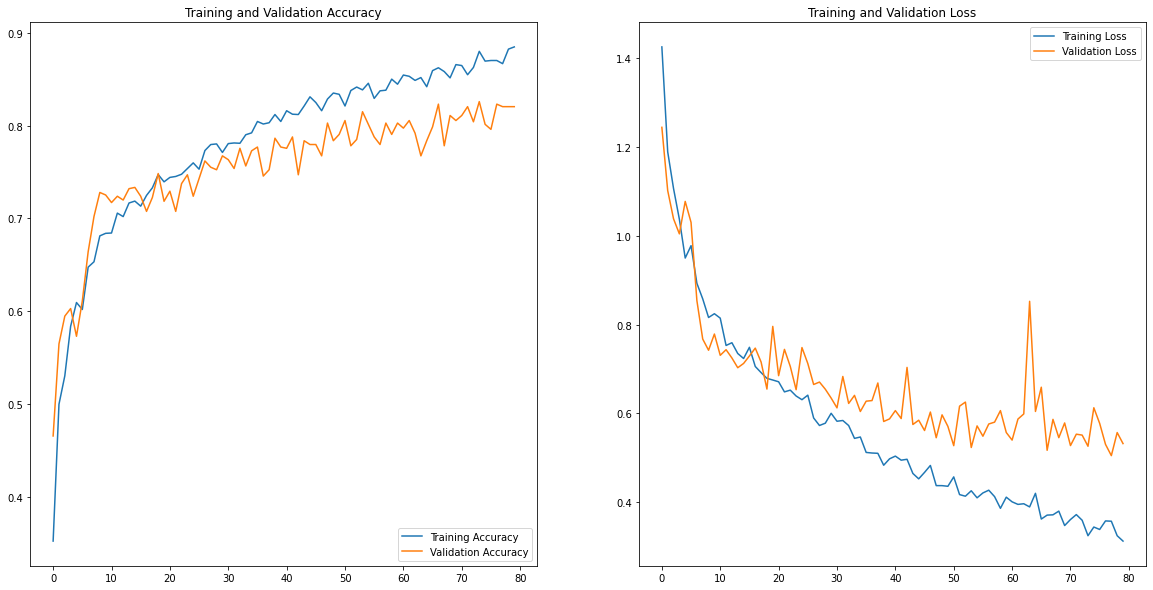

In [20]:
# Display the Accuracy and Loss for both Training and Validation dataset

accuracy = result.history['accuracy']
validation_accuracy = result.history['val_accuracy']

loss = result.history['loss']
validation_loss = result.history['val_loss']

epochs_range = range(80)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()